## Extraction des données de débit 6mn du  RAD stockées dans BigQuery
A titre de démonstration, les données 2019 de débit 6mn de 150 stations ont été placées dans une base BigQuery.

BigQuery est un service proposé par la Google Cloud Platform (GCP).

Pour permettre des applications temps réel, il faudrait que SIRIUS alimente BigQuery en continu (toutes les minutes ?).

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np,io,codecs,json
from random import *
from datetime import datetime
import matplotlib.colors as mcolors
from ipywidgets import *
from google.cloud import bigquery
from google.oauth2 import service_account
def qrSt(stV,dtDeb,dtFin):
    d1=str(dtDeb.value.timetuple().tm_yday)
    d2=str(dtFin.value.timetuple().tm_yday)   
    q1 = """
    SELECT P6mn,Db,jr FROM (
        SELECT  Stat,P6mn,Db,EXTRACT(year FROM dt) AS an,EXTRACT(dayofyear FROM dt) AS jr FROM
          `dirif25.6mn.bsDbt1` WHERE Stat=\""""
    q2="\"  ) WHERE  an=2019 and (jr+1)>"
    q3=" and (jr-1)<"
    q4=" order by jr,P6mn"
    query=q1+stV+q2+d1+q3+d2+q4
    res=client.query(query).to_dataframe().astype(int)
    res['date']=pd.to_datetime(2019000+res['jr'],format='%Y%j'   )
    return res[['date','P6mn','Db']]
print('Pour utiliser ce service, il faut disposer d\'un compte sur Google Cloud Platform (GCP) et créer un "service_account". ')
print('GCP permet de créer un fichier (.json) qui contient la clé de ce compte. ')
print('Importer ci-dessous ("upload") le fichier de la clé du "service_account". ')
def on_upload_change(change):
    global client,dic
    upl_dc=codecs.decode((list(upl.value.values())[0]['content']))
    credentials=service_account.Credentials.from_service_account_info(json.loads(upl_dc))
    client = bigquery.Client(credentials= credentials,project='dirif25')
    quer="""
    Select distinct Stat,Axe from `dirif25.6mn.lstSt`
    """
    lstSt=client.query(quer).to_dataframe()
    lstAx=list(lstSt['Axe'].unique())
    dic={}
    for x in lstAx:
        dic[x]=list(lstSt[lstSt['Axe']==x]['Stat'].sort_values().values)        
upl=FileUpload()
display(upl)
upl.observe(on_upload_change, names='_counter')

Pour utiliser ce service, il faut disposer d'un compte sur Google Cloud Platform (GCP) et créer un "service_account". 
GCP permet de créer un fichier (.json) qui contient la clé de ce compte. 
Importer ci-dessous ("upload") le fichier de la clé du "service_account". 


FileUpload(value={}, description='Upload')

##  Axe et point de mesure

In [20]:
print('Choisir, dans un premier temps, l\'axe du point de mesure, dans la liste déroulante.\nPuis, sélectionner le point de mesure.')
axeW = Dropdown(options = dic.keys())
statW = Dropdown(options = dic[axeW.value])
@interact(Axe = axeW, PointMesure = statW)
def print_city(Axe, PointMesure):
   statW.options = dic[Axe]

Choisir, dans un premier temps, l'axe du point de mesure, dans la liste déroulante.
Puis, sélectionner le point de mesure.


interactive(children=(Dropdown(description='Axe', options=('A1-W', 'A1-Y', 'A3-W', 'A3-Y', 'A4-W', 'A4-Y', 'A6…

## Période d'extraction

In [16]:
dtDeb=widgets.DatePicker(description='Début', value=datetime(2019,1,3))
dtFin=widgets.DatePicker(description='Fin', value=datetime(2019,10,31))
print('Renseigner ci-dessous la période pour laquelle faire une extraction')
VBox([dtDeb,dtFin])


Renseigner ci-dessous la période pour laquelle faire une extraction


## Export de la sélection

In [56]:
resultat=qrSt(statW.value,dtDeb,dtFin)
fch='expDb6mn'+statW.value.split('/')[0]+statW.value.split('/')[1][:2]+'_d'+str(dtDeb.value)[5:]+'_f'+str(dtFin.value)[5:] + '.csv'
resultat.to_csv(fch)

Les données manquantes sont en jaune


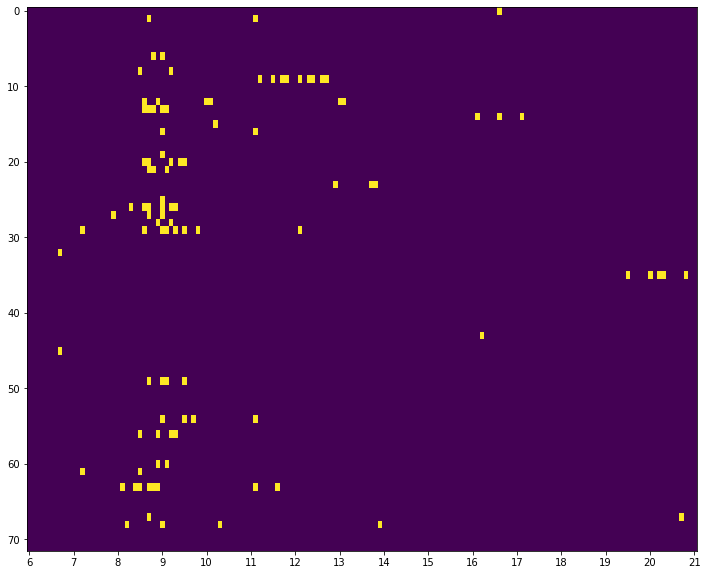

In [57]:
res=resultat[(resultat['P6mn']>59)&(resultat['P6mn']<211)]
res=(res.set_index(['date','P6mn'])).isna().unstack('P6mn').fillna(True).astype(int)
fig,ax=plt.subplots(figsize=(12,10))
ax.imshow(res,aspect='auto')
ax.set_xticks([x*10 for x in range(16)])
ax.set_xticklabels(range(6,22))
print('Les données manquantes sont en jaune')

'expDb6mnN104-E10_d03-01_f05-31.csv'